### Libraries

In [9]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import matplotlib
# import time
import seaborn as sns
import pickle as pkl
from itertools import count
from collections import namedtuple, deque
# import numba # for speed up
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns
import tqdm
import os
import pandas as pd
import sys
# import modules.agents as agents # for different agents
# import modules.architectures as architectures # for different architectures
sys.path.append('../')

In [10]:
# # if you want to run the script on colab, uncomment the following lines
# sys.path.append('./drive/My Drive')
# from google.colab import drive
# drive.mount('/content/drive')
import modules.agents as agents # for different agents
import modules.architectures as architectures # for different architectures
import modules.envs as envs # for Game2048Env
import modules.stats as stats # for plotting results

### Utils for playing the game for random agent

In [11]:
stats.compare_agents(agent=agent, num_episodes=100)

In [19]:
env = envs.Game2048Env(log_rewards=True)
env.reset()
agent = agents.RandomAgent()
g = play_games(env, agent, n_games=50, verbose=False)
# create a dataframe from the results
df = pd.DataFrame(g)

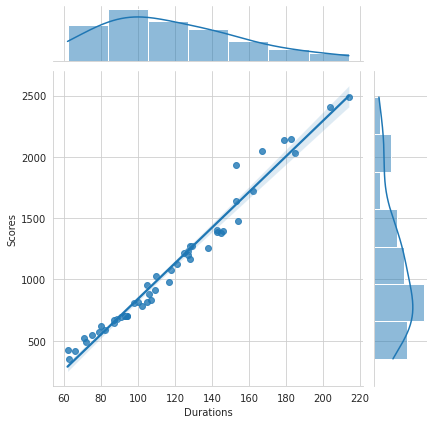

In [20]:
# set a figure size
sns.jointplot(x="Durations", y="Scores", data=df, kind="reg")
# change the style of the plot
sns.set_style("whitegrid")
plt.show()

### Class Definitions for 2048 game
First of all, we need to define the class for the game.

The class will contain some key attributes, like the game board, and the score.

The game board is a 4x4 matrix, and the score is an integer.

### DQN algorithm
https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

https://huggingface.co/blog/deep-rl-dqn

In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [8]:
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = architectures.FatConvolutionalNetwork(l2_regularization=3e-4).to(device)


agent = agents.ConvDQN_Agent(model=model,
                        device=device,
                        gamma=0.995,
                        replay_memory_size=10000,
                        batch_size=384,
                        eps_start=0.8,
                        eps_end=0.02, 
                        eps_decay=1000,             
                        tau=5e-3,
                        kind_action="entropy",
                        lr=1e-3)

print("Number of parameters: ", count_parameters(model))

load = False
save = True
num_episodes = 1

env = envs.Game2048Env(log_rewards=True)

if load:
    agent.load("trained_architectures/convdqn_agent.pt")

agent.fit(env, num_episodes=num_episodes, verbose=True)

if save:
    agent.save("trained_architectures/convdqn_agent.pt")

# tau = 1e-5<
# lr = 1e-3
# l2_reg = 5e-5

Number of parameters:  211216


100%|██████████| 1/1 [00:15<00:00, 15.85s/it]

Episode 0 Loss 0.0 Max tile: 64.0 Max duration: 91.0
Episode 0 finished after 92 steps. Max tile: 64.0


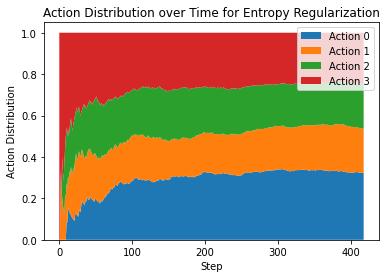

In [ ]:
agent.action_dist
# convert action distribution to numpy array
action_dist = np.array(agent.action_dist)
# make a stackplot of the action distribution
plt.stackplot(np.arange(len(action_dist)), action_dist.T, labels=[f"Action {i}" for i in range(4)])
plt.legend(loc='upper right')
plt.xlabel("Step")
plt.ylabel("Action Distribution")
plt.title("Action Distribution over Time for Entropy Regularization")
plt.show()

In [ ]:
print(agent.policy_net)
# take the weights of fully connected layers and take the sum of the modules 
fc = np.sum(np.abs(agent.policy_net.fc.weight.data.cpu().numpy()))
fc2 = np.sum(np.abs(agent.policy_net.fc2.weight.data.cpu().numpy()))
fc3 = np.sum(np.abs(agent.policy_net.fc3.weight.data.cpu().numpy()))
# sum the weights of the convolutional layers and divide by the number of weights
6/(0.075*(agent.policy_net.fc.weight.numel() + agent.policy_net.fc2.weight.numel() + agent.policy_net.fc3.weight.numel() + agent.policy_net.fc4.weight.numel()))

FatConvolutionalNetwork(
  (conv): Conv3d(1, 4, kernel_size=(2, 4, 4), stride=(1, 1, 1))
  (bnc): BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=44, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=512, out_features=128, bias=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=128, out_features=4, bias=True)
)


0.00038390663390663394

In [ ]:
6/(fc + fc2 +fc3)

0.0009335805457860173

100%|██████████| 100/100 [03:00<00:00,  1.81s/it]


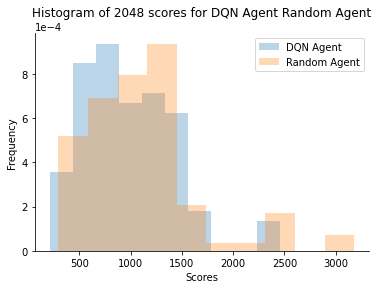

In [ ]:
compare_agents = True
if compare_agents:
    num_episodes = 100
    scores_agent = agent.test(env, num_episodes=num_episodes)
    env = envs.Game2048Env(log_rewards=True)
    random_agent = agents.RandomAgent()
    scores_random_player = play_games(env, random_agent, n_games=num_episodes, verbose=False)['Scores']
    stats.hist_agent_scores((scores_agent, scores_random_player), names_agents=["DQN Agent", "Random Agent"], bins=np.floor(np.sqrt(num_episodes)).astype(int))

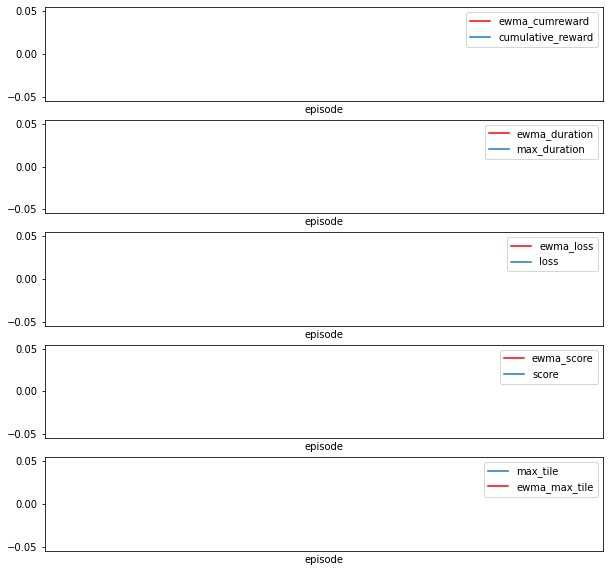

In [ ]:
# plot the 5 main metrics of the agent
stats.plot_5_metrics(agent)
plt.show()